## Advanced Lane Line Detection Laboratory

In this notebook, a pipeline of advanced lane line detection algorithm will be developed and experimented.

In [1]:
# Packages import
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
%matplotlib inline

### Step 0 - Show Test Image

In [2]:
import os
Imag_dir = "../test_images/"
TestImag_list = os.listdir(Imag_dir)

test_images = []
for i in range (8):
    image = mpimg.imread(Imag_dir + TestImag_list[i])
    test_images.append(image)

Height,Width,channel = test_images[1].shape
print(Height,Width,channel)

720 1280 3


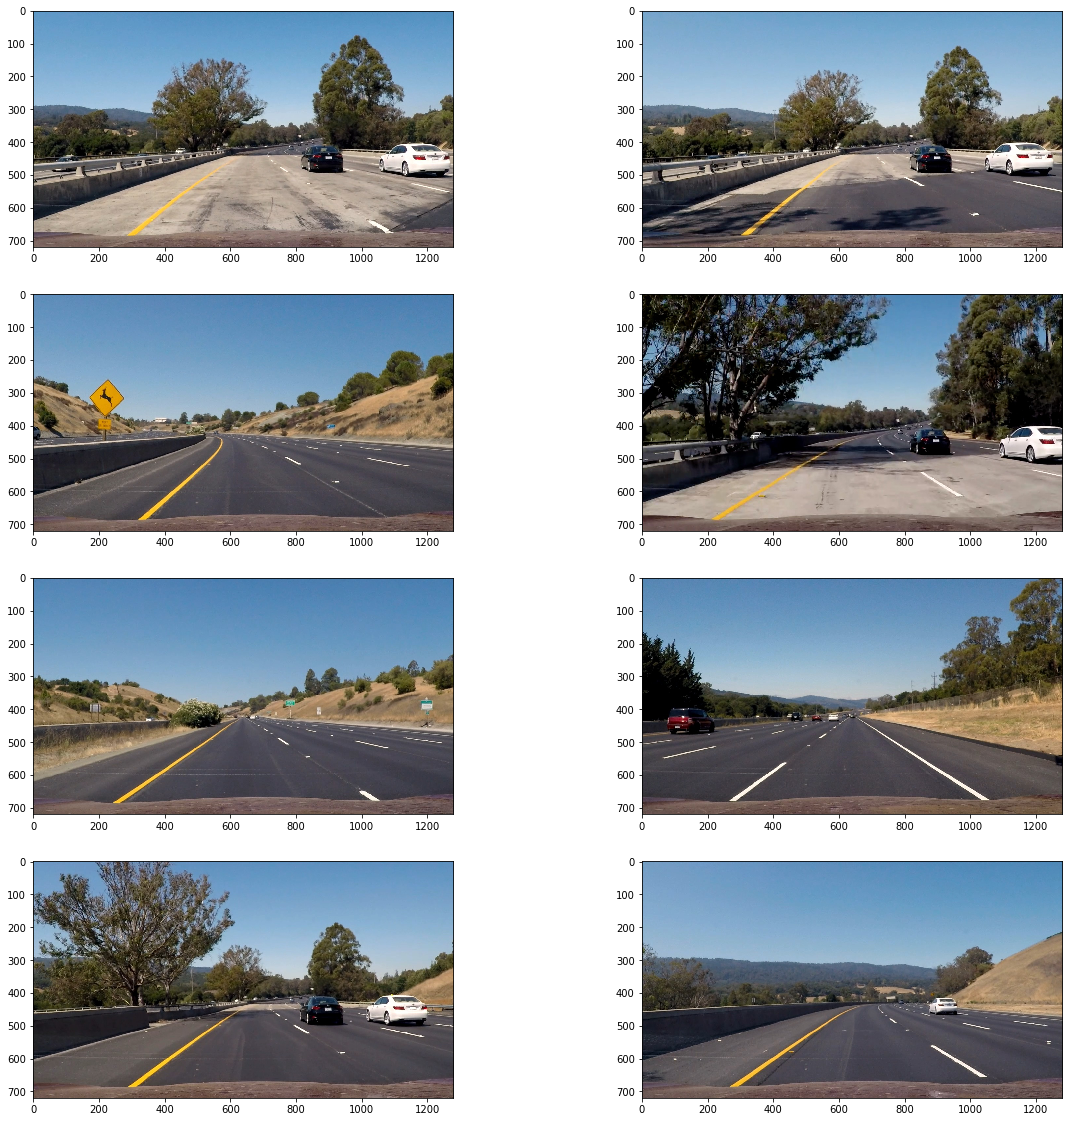

In [6]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(test_images[i])
    

### Step 1 - Camera Calibration

#### Preparing Calibration Points

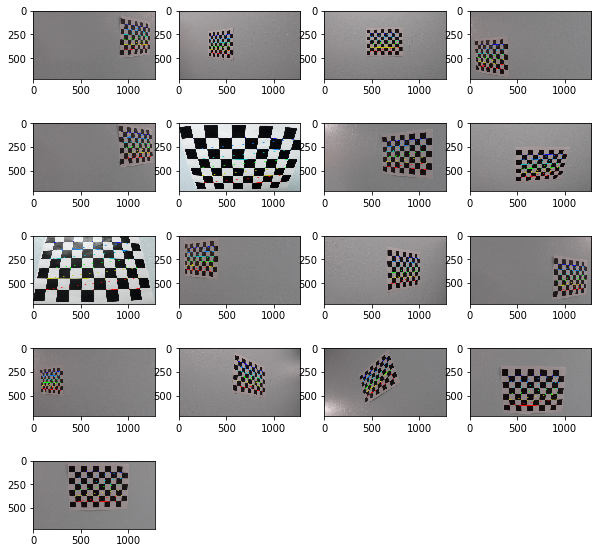

In [41]:
#-------------Prepare for the chessboard images-------------
chessbImages = glob.glob("../camera_cal/calibration*.jpg")

#--------------going through each image to obtain the imagepoints and objectpoints--------------
imagespoints = []
objectpoints = []
cornerImag = []

# preload the object points
objp = np.zeros((6*9,3),np.float32)
objp[:,0:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # generate an array with each row containing (x,y,z) for each conner

# looping through each image
for fname in chessbImages:
    img = cv2.imread(fname)
    
    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find chessboard corner
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If found, draw corners
    if ret == True:
        imagespoints.append(corners)
        objectpoints.append(objp)
        cv2.drawChessboardCorners(img, (9, 6), corners, ret)
        cornerImag.append(img)
        
# show the chessboard images with corners marked 
fig = plt.figure(figsize = (10,10))
for i in range (len(cornerImag)):
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(cornerImag[i])

#### Calculate the Correction Matrix

In [70]:
img = cv2.imread("../camera_cal/calibration1.jpg")
imag_size = (img.shape[1],img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagespoints, imag_size, None, None)

# Save the camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ))

Now, we can try some images to see how the calibration works

Text(0.5, 1.0, 'undistorted image')

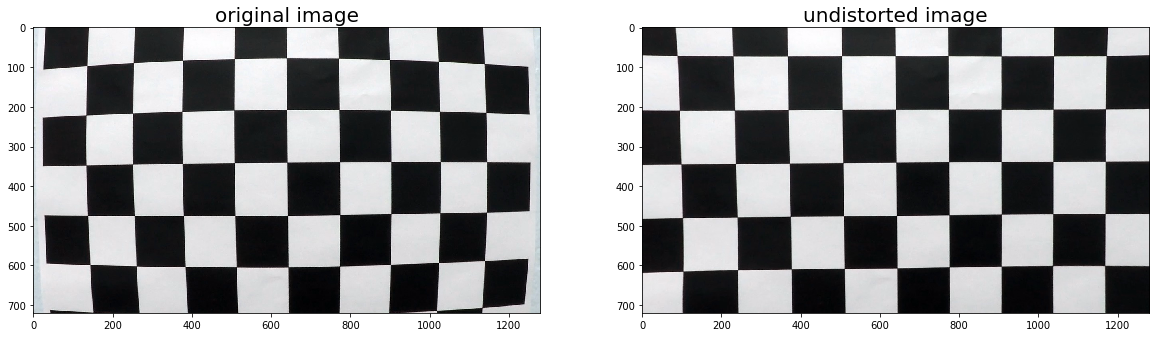

In [69]:
img = cv2.imread("../camera_cal/calibration1.jpg")
dst = cv2.undistort(img, mtx, dist, None, mtx)

f,(ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title("original image", fontsize = 20)
ax2.imshow(dst)
ax2.set_title("undistorted image", fontsize = 20)

### Step 2 - Undistort the Images

In [43]:
# Read in the saved undistortion matrix
dist_pickle = pickle.load( open( "calibration.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undisImag = []
for i in range (8):
    undisImag.append(cv2.undistort(test_images[i], mtx, dist, None, mtx))

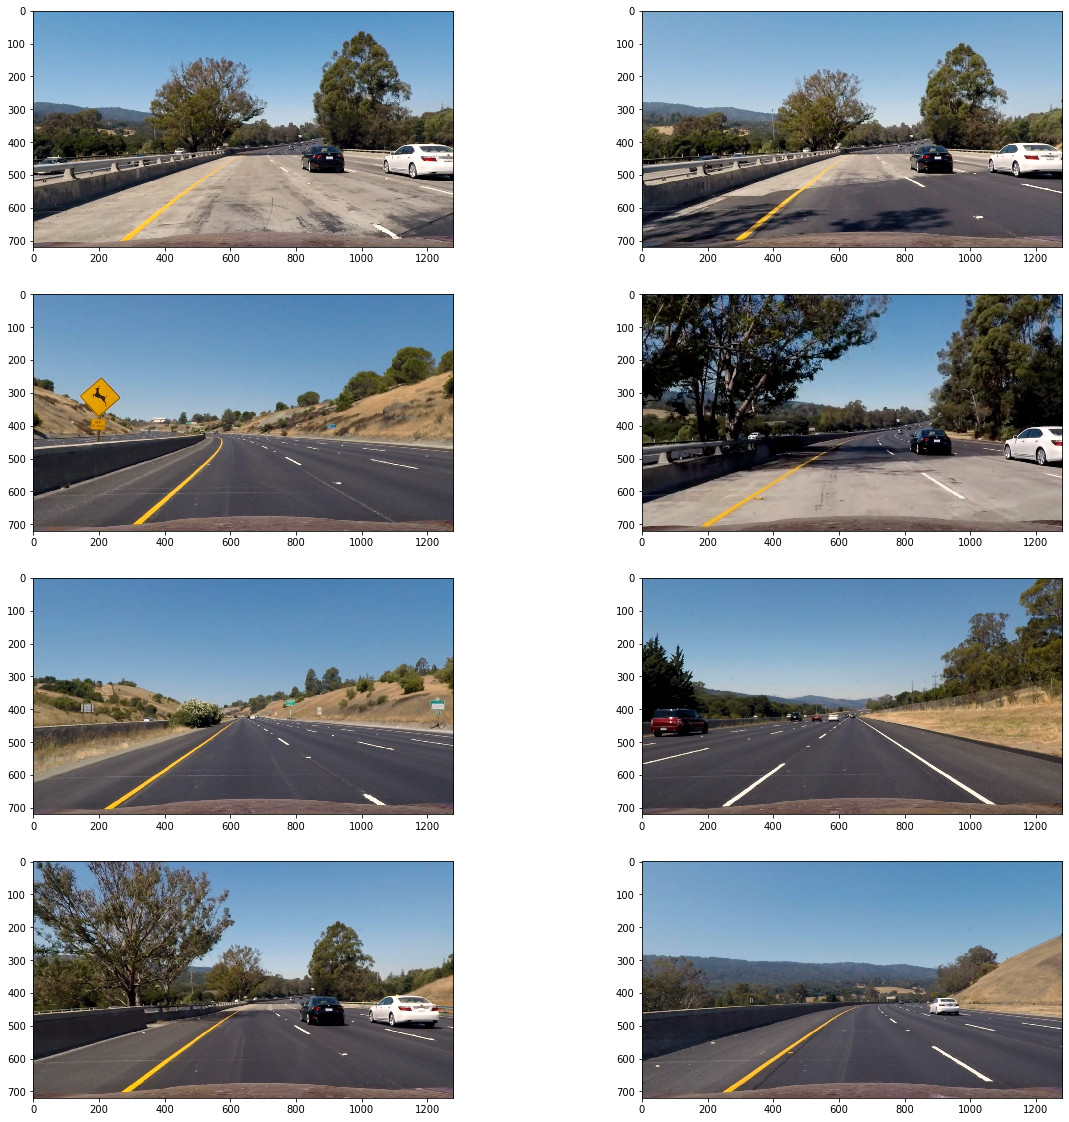

In [44]:

fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(undisImag[i])

### Step 3 - Threshold-out the Lanes

First, build the filters that might be used.

In [38]:
# build the filters that might be used
def sobel_abs_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def sobel_mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def color_threshold(img, colorMode = 'HLS', channel = 'S', thresh = (170, 255)):
    # experiment with different color thresholding methods
    if colorMode == 'HLS':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        ChInx = {'H':0,'L':1,'S':2}
        Ch_thresh = image[:,:,ChInx[channel]]
        
    elif colorMode == 'HSV':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        ChInx = {'H':0,'S':1,'V':2}
        Ch_thresh = image[:,:,ChInx[channel]]
        
    elif colorMode == 'RGB':
        ChInx = {'R':0,'G':1,'B':2}
        Ch_thresh = img[:,:,ChInx[channel]]
        
    else:
        print ("colorMode incorrrect")
        return 0
    
    # convert to 0-255
    Ch_thresh = 255 * (Ch_thresh / np.max(Ch_thresh))
    # apply threshold
    binary_output = np.zeros_like(Ch_thresh)
    binary_output[(Ch_thresh > thresh[0]) & (Ch_thresh <= thresh[1])] = 1
    
    return binary_output
        

Experiment the combinations of the filters that generates the best lane pixels.

In [87]:
def combined_thresh (img, sobel_kernel = 3, abs_thresh = (20,100), mag_thresh = (30,100),\
                     dir_thresh = (0.7,1.3), colorMode = 'HLS', channel = 'S', col_thresh = (80,255)):
    
    gradx = sobel_abs_thresh(img, orient='x', sobel_kernel=sobel_kernel, thresh=abs_thresh)
    grady = sobel_abs_thresh(img, orient='y', sobel_kernel=sobel_kernel, thresh=abs_thresh)
    mag_binary = sobel_mag_thresh(img, sobel_kernel=sobel_kernel, mag_thresh=mag_thresh)
    dir_binary = sobel_dir_threshold(img, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    col_binary = color_threshold(img, colorMode = colorMode, channel = channel, thresh = col_thresh)
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | \
                    ((mag_binary == 1) & (dir_binary == 1))| \
                    (col_binary == 1) ] = 1
    
    return combined_binary

In [103]:
threshImg = []
for i in range (8):
    img = combined_thresh (undisImag[i], sobel_kernel = 13, abs_thresh = (20,100), mag_thresh = (30,100),\
                           dir_thresh = (0.7,1.3), colorMode = 'HSV', channel = 'V', col_thresh = (170,255))  
    threshImg.append(img)
    

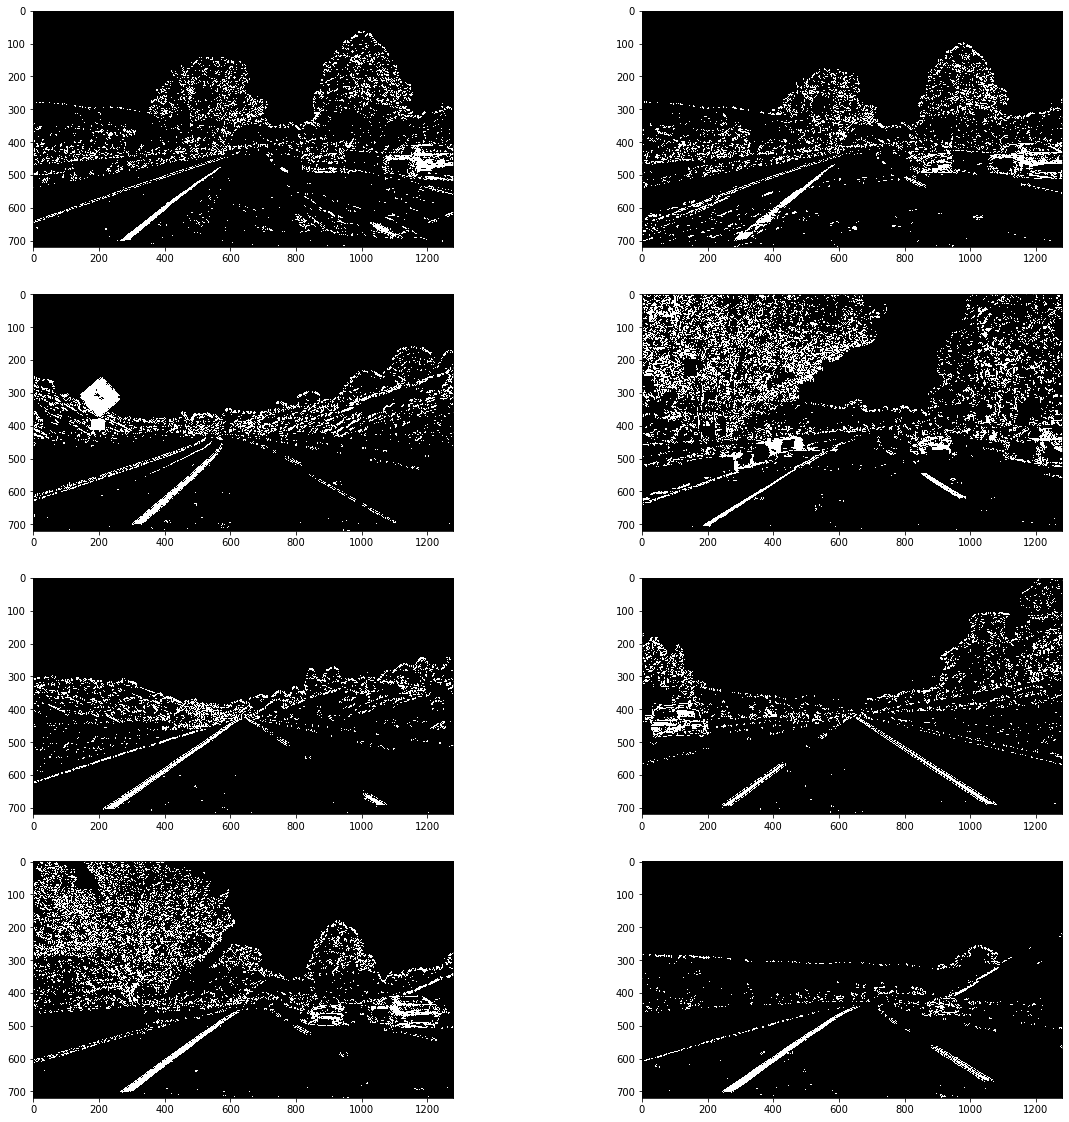

In [104]:
fig = plt.figure(figsize = (20,20))
for i in range (8):
    ax = fig.add_subplot(4,2,i+1)
    ax.imshow(threshImg[i],cmap = 'gray')

### Step 4 - Perspective Transformation

In [78]:
# define a function to do the perspective transformation
def warp_imag(img,dst,src):
    img_size = (img.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped,M,Minv

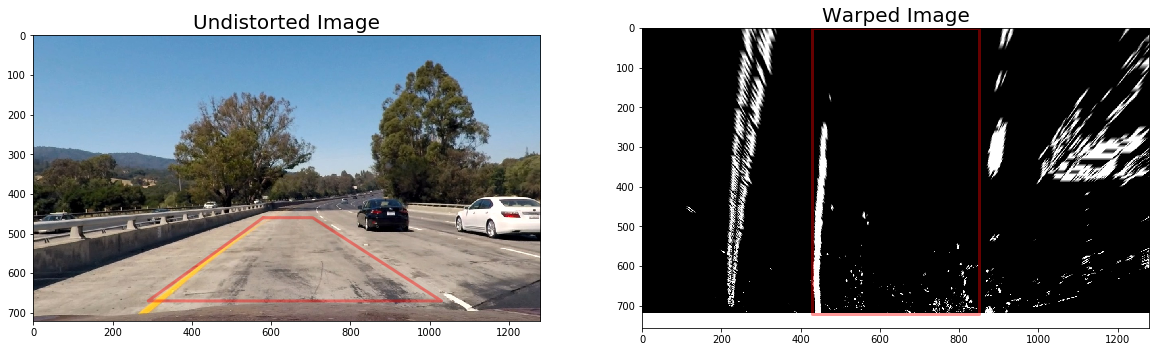

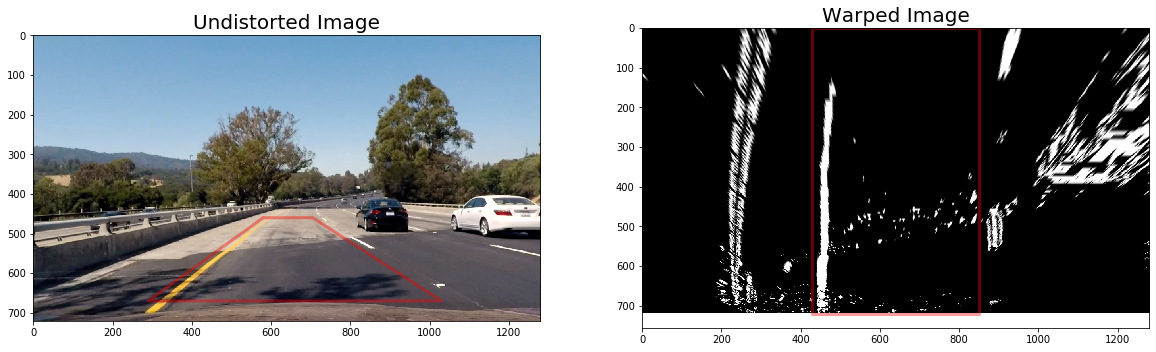

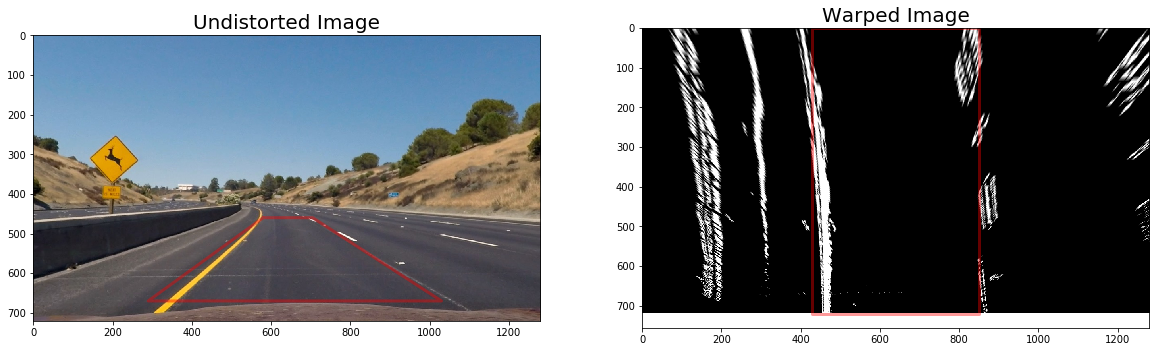

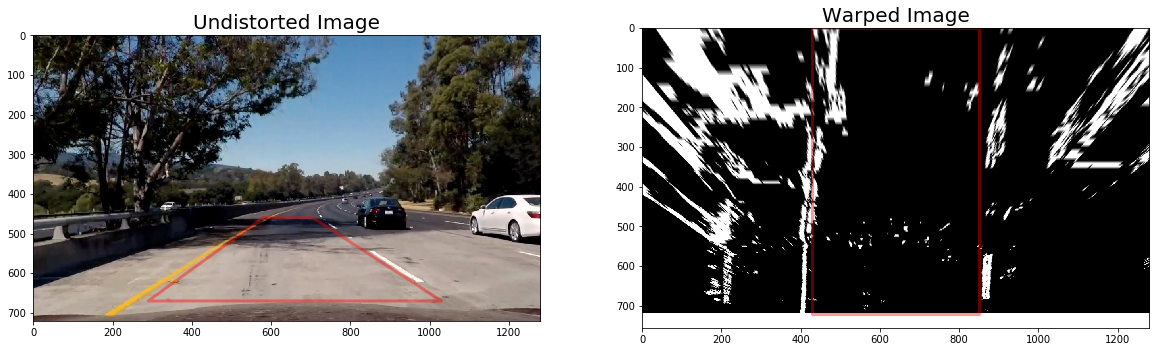

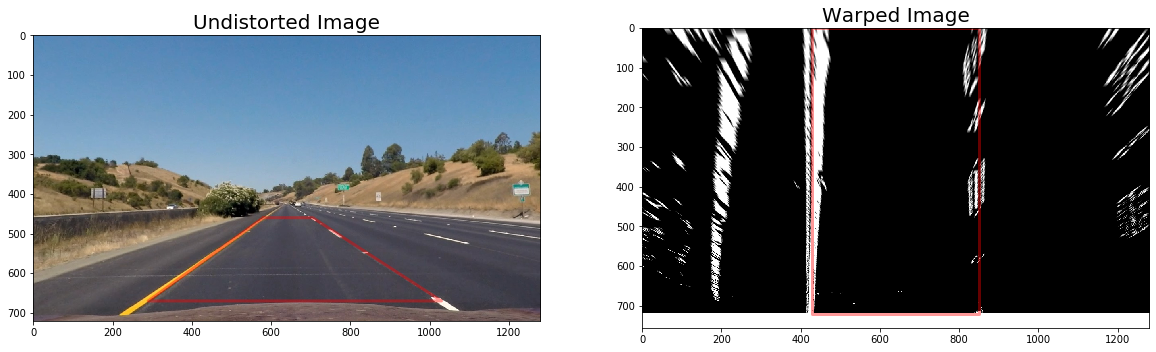

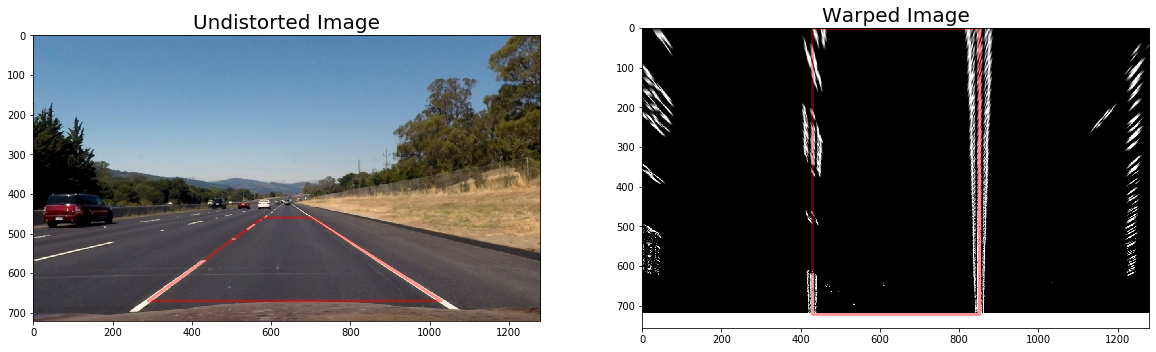

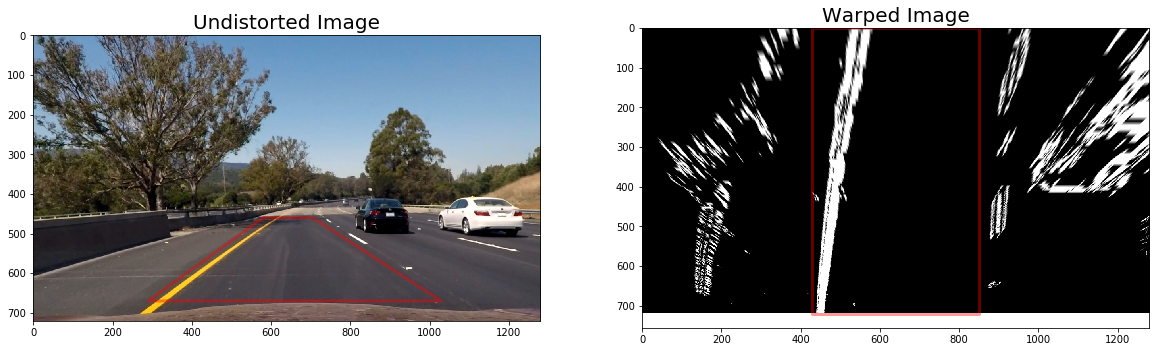

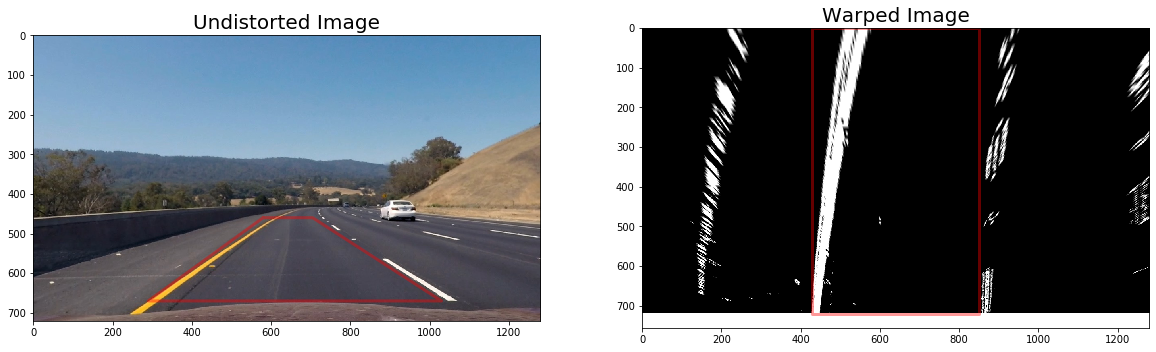

In [105]:
# define source and destination points for transform
# source points should form a trapezoidal, the destination points should be a rectangle
# find an image with straight lanes, overlap the trapezoidal on the image, then make sure the warped image
# has the rectangle aligned with the lanes

src = np.float32([(580,460),
                  (705,460), 
                  (290,670), 
                  (1030,670)])

dst = np.float32([(430,0),
                  (850,0),
                  (430,720),
                  (850,720)])

warpedImg = []
for i in range (8):
    
    wImg,M,Minv = warp_imag(threshImg[i],dst,src)
    warpedImg.append(wImg)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undisImag[i],cmap='gray')
    x = [src[0][0],src[1][0],src[3][0],src[2][0],src[0][0]]
    y = [src[0][1],src[1][1],src[3][1],src[2][1],src[0][1]]
    ax1.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(wImg,cmap='gray')
    x = [dst[0][0],dst[1][0],dst[3][0],dst[2][0],dst[0][0]]
    y = [dst[0][1],dst[1][1],dst[3][1],dst[2][1],dst[0][1]]
    ax2.plot(x, y, color='r', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax2.set_title('Warped Image', fontsize=20)

### Step 4 - 